In [1]:
# Google Colabでの設定
google_colab = True

if google_colab:
    from google.colab import drive
    from google.colab import userdata

    drive.mount("/content/drive")

    # ディレクトリ移動
    %cd /content/drive/MyDrive/Python/kaggle_map/src/qwen2.5-14b-instruct-stage1_exp001

    !pip install -q bitsandbytes trl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Python/kaggle_map/src/qwen2.5-14b-instruct-stage1_exp001


In [2]:
import os
import gc
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch
import wandb
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType
from trl import SFTConfig, SFTTrainer

In [3]:
class CFG:
    """実験設定管理クラス"""

    # ============== 実験情報 =============
    comp_name = "kaggle_map"
    exp_name = "qwen2.5-14b-instruct-stage1_exp001"
    model_name = "Qwen/Qwen2.5-14B-Instruct"

    # ============== ファイルパス設定 =============
    comp_dir_path = "../../kaggle/input/"
    comp_dataset_path = f"{comp_dir_path}/map-charting-student-math-misunderstandings/"
    output_dir_path = "output/"
    log_dir_path = "logs/"

    # ============== モデル設定 =============
    max_len = 256

    num_train_epochs = 3
    per_device_train_batch_size = 32
    gradient_accumulation_steps = 1
    per_device_eval_batch_size = 32
    optim_type = "adamw_torch"
    learning_rate = 5e-5
    lr_scheduler_type = "cosine"
    warmup_steps = 50
    weight_decay = 0.01

    lora_r = 16
    lora_alpha = 32
    lora_dropout = 0.05
    lora_bias = "none"
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

    # ============== その他設定 =============
    seed = 42
    device = torch.device("cuda")

In [4]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.output_dir_path, cfg.log_dir_path]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg):
    set_seed(cfg.seed)
    make_dirs(cfg)

# 1. LLMの学習

## 1.1 データの読み込み

In [5]:
# データ読み込み
train = pd.read_csv(f"{CFG.comp_dataset_path}/train.csv")
print(train.shape)
train.head(2)

(36696, 7)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN


## 1.2 前処理

In [6]:
def add_folds_by_qid_cat_misc(df, n_splits=5, random_state=42, fallback="pair"):
    s_qid = df["QuestionId"].astype(str).fillna("NA")
    s_cat = df["Category"].astype(str).fillna("NA")
    s_misc = df["Misconception"].astype(str).fillna("NA")

    y_triple = s_qid + "|" + s_cat + "|" + s_misc
    y_pair = s_cat + "|" + s_misc

    cnt = y_triple.value_counts()
    if (cnt < n_splits).any():
        if fallback == "pair":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, y_pair, y_triple)
        elif fallback == "category":
            rare = y_triple.map(cnt) < n_splits
            y = np.where(rare, s_cat, y_triple)
        elif fallback == "none":
            y = y_triple
        else:
            raise ValueError("fallback は 'pair' / 'category' / 'none' のいずれかにしてください。")
    else:
        y = y_triple

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    folds = np.full(len(df), -1, dtype=int)
    for fold, (_, val_idx) in enumerate(skf.split(np.zeros(len(df)), y)):
        folds[val_idx] = fold

    out = df.copy()
    out["fold"] = folds
    return out

In [7]:
# fold分割
train = add_folds_by_qid_cat_misc(train, n_splits=5, random_state=42, fallback="pair")
train["fold"].value_counts()

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,count
fold,
0,7340
1,7339
4,7339
2,7339
3,7339


In [8]:
# 間違っている正解ラベルを修正(MEMO: trainのみに適用しないとCV/LBの相関がとれないが、一旦無視)
false_to_true_ids = [12878, 12901, 13876, 14089, 14159, 14185]
train["Category"] = np.where(train["row_id"].isin(false_to_true_ids), train["Category"].str.replace("False", "True"), train["Category"])

true_to_false_ids = [14280, 14305, 14321, 14335, 14338,  14352, 14355, 14403, 14407, 14412, 14413, 14418]
train["Category"] = np.where(train["row_id"].isin(true_to_false_ids), train["Category"].str.replace("True", "False"), train["Category"])

In [9]:
# 修正されたラベルが含まれるfold
for f in range(5):
    ids = train[(train["fold"] == f) & (train["row_id"].isin(false_to_true_ids) | train["row_id"].isin(true_to_false_ids))]["row_id"].values
    print(f"Fold {f}: {ids}")

Fold 0: [12878 14159]
Fold 1: [14280 14305 14338 14407]
Fold 2: [14089 14335 14355]
Fold 3: [13876 14185 14418]
Fold 4: [12901 14321 14352 14403 14412 14413]


In [10]:
# ラベルの作成
train["target"] = train.Category

# ラベルエンコード
le = LabelEncoder()
train["label"] = le.fit_transform(train["target"])

n_classes = len(le.classes_)
print(f"訓練データの形状: {train.shape} - {n_classes}個のターゲットクラス")
train.head(2)

訓練データの形状: (36696, 10) - 6個のターゲットクラス


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,fold,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN,1,True_Correct,3
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN,4,True_Correct,3


## 1.3 特徴量エンジニアリング

In [11]:
# 正解フラグの作成
idx = train.apply(lambda row: row.Category.split("_")[0], axis=1) == "True"
correct = train.loc[idx].copy()
correct["c"] = correct.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
correct = correct.sort_values("c", ascending=False)
correct = correct.drop_duplicates(["QuestionId"])
correct = correct[["QuestionId", "MC_Answer"]]
correct["is_correct"] = 1

# 正解ラベルを訓練データにマージ
train = train.merge(correct, on=["QuestionId", "MC_Answer"], how="left")
train.is_correct = train.is_correct.fillna(0)

## 1.4 tokenize処理

In [12]:
# tokenizerの読み込み
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

In [13]:
# 学習データのtokenizer処理
def format_input(row):
    x = "Yes"
    if not row["is_correct"]:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct: {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train["text"] = train.apply(format_input, axis=1)
print("LLMへのプロンプト例:")
print()
print(train.text.values[0])

LLMへのプロンプト例:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct: Yes
Student Explanation: 0ne third is equal to tree nineth


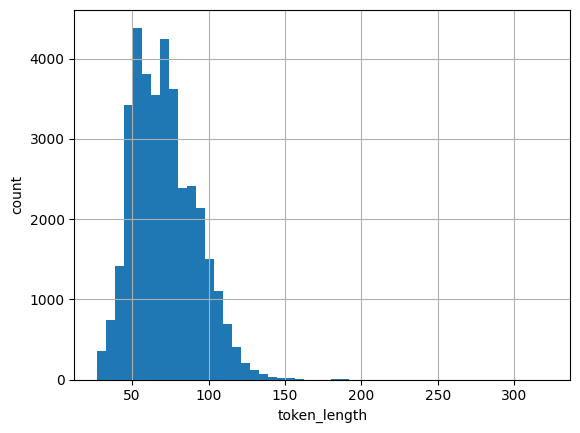

256トークンを超える訓練サンプルが1個あります


array([ 27,  27,  27, ..., 190, 227, 322])

In [14]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]

# トークン長の分布を可視化
plt.hist(lengths, bins=50)
plt.xlabel("token_length")
plt.ylabel("count")
plt.grid(True)
plt.show()

# max_lenを超えるサンプル数を確認
L = (np.array(lengths) > CFG.max_len).sum()
print(f"{CFG.max_len}トークンを超える訓練サンプルが{L}個あります")
np.sort(lengths)

In [15]:
# 訓練データと検証データに分割
train_df = train[train.fold != 0]
val_df = train[train.fold == 0]

# Hugging Faceデータセットに変換
COLS = ["text", "label"]
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

In [16]:
# トークナイズ関数
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# PyTorch用のフォーマットを設定
columns = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=columns)
val_ds.set_format(type="torch", columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

## 1.5 学習設定

In [17]:
# wandbのログイン
wandb.login(key=userdata.get("WANDB_API_KEY"))
wandb.init(project=CFG.comp_name, name=CFG.exp_name)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tomokazu_rikioka (tomokazu_rikioka_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
# 量子化の設定
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4"
)

# モデルの読み込み
model = AutoModelForSequenceClassification.from_pretrained(
    CFG.model_name,
    quantization_config=bnb_config,
    num_labels=n_classes,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-14B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# 学習の設定
training_args = TrainingArguments(
    output_dir=CFG.output_dir_path,
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps",
    num_train_epochs=CFG.num_train_epochs,
    per_device_train_batch_size=CFG.per_device_train_batch_size,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    per_device_eval_batch_size=CFG.per_device_eval_batch_size,
    learning_rate=CFG.learning_rate,
    optim=CFG.optim_type,
    lr_scheduler_type=CFG.lr_scheduler_type,
    warmup_steps=CFG.warmup_steps,
    weight_decay=CFG.weight_decay,
    logging_dir=CFG.log_dir_path,
    logging_steps=50,
    save_steps=600,
    eval_steps=600,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="wandb",
    bf16=True,
    fp16=False,  # KaggleはT4なのでFP16で推論
)

In [20]:
# LoRAの設定
lora_config = LoraConfig(
    r=CFG.lora_r,
    lora_alpha=CFG.lora_alpha,
    lora_dropout=CFG.lora_dropout,
    bias=CFG.lora_bias,
    target_modules=CFG.target_modules,
    task_type=TaskType.SEQ_CLS,
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [21]:
# カスタムメトリック（正解率）
def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

## 1.6 モデルの学習

In [22]:
# トレーナーの設定
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_accuracy,
)

# モデルの学習
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy
600,0.464000,0.418301,0.818665
1200,0.257300,0.312871,0.876294
1800,0.250400,0.279507,0.889782
2400,0.124900,0.340147,0.891689


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/

TrainOutput(global_step=2754, training_loss=0.33504566373864897, metrics={'train_runtime': 19610.5668, 'train_samples_per_second': 4.491, 'train_steps_per_second': 0.14, 'total_flos': 1.7966578858060677e+18, 'train_loss': 0.33504566373864897, 'epoch': 3.0})

## 1.7 モデルの保存

In [23]:
trainer.save_model(f"{CFG.output_dir_path}/model")
tokenizer.save_pretrained(f"{CFG.output_dir_path}/tokenizer")

('output//tokenizer/tokenizer_config.json',
 'output//tokenizer/special_tokens_map.json',
 'output//tokenizer/chat_template.jinja',
 'output//tokenizer/vocab.json',
 'output//tokenizer/merges.txt',
 'output//tokenizer/added_tokens.json',
 'output//tokenizer/tokenizer.json')

In [24]:
# WandBのセッションを終了
with wandb.init():
    wandb.finish()

eval/accuracy,▁▇██
eval/loss,█▃▁▄
eval/runtime,▄▁█▇
eval/samples_per_second,▆█▁▃
eval/steps_per_second,▁▁▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▄▄▆▄▄▅▃▄▄▃▃▂▅▂▂▂▂▃▁▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▂▂▁▂
train/learning_rate,████████▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
train/loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.89169


In [25]:
# キャッシュ削除
del model, tokenizer, trainer
gc.collect()
torch.cuda.empty_cache()

# 2. 結果分析

## 2.1 検証データの予測

In [26]:
# 学習済みモデルの読み込み
model_path = f"{CFG.output_dir_path}/model"
tokenizer_path = f"{CFG.output_dir_path}/tokenizer"

inference_model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=n_classes,
    reference_compile=False,
)
inference_tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# 推論用のインスタンスを作成
inference_trainer = Trainer(
    model=inference_model,
    processing_class=inference_tokenizer
)

# 検証データの推論実行
inference_model.eval()
start_time = time.time()

val_predictions = inference_trainer.predict(val_ds)
logits = val_predictions.predictions
val_labels = val_predictions.label_ids

# 推論時間を計算
inference_time = time.time() - start_time
print(f"推論時間: {inference_time:.2f}秒")
print(f"サンプル数: {len(val_labels)}個")
print(f"1サンプルあたりの推論時間: {inference_time/len(val_labels)*1000:.2f}ms")

# 確率値に変換
val_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

# Top-1精度の計算
val_pred_labels = np.argmax(logits, axis=1)
accuracy = (val_pred_labels == val_labels).mean()
print(f"\nTop-1精度: {accuracy:.4f}")

TypeError: GenericForSequenceClassification.__init__() got an unexpected keyword argument 'reference_compile'